In [19]:
!open .

In [1]:
import pandas as pd
import requests
import bs4
import math
import time
import NeoQuant as nq
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
pd.set_option('display.max_colwidth', -1)
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 500)

## get all company list

In [2]:
companies = nq.get_all_company_list()

## set company name

In [3]:
# company_name = '현대건설'
company_name = '삼성전자'
company_code = nq.get_company_code(company_name, companies)
print('company name : ' + company_name)
print('company code : ' + company_code)

company name : 삼성전자
company code : 005930


## get base profit ratio

In [4]:
base_profit_ratio = nq.get_base_profit_ratio()
base_profit_ratio

8.26

## get fnguide snapshot

In [5]:
if not company_code.startswith('A'):
    company_code = 'A' + company_code

snapshot_url = 'http://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?pGB=1&cID=&MenuYn=Y&ReportGB=&NewMenuID=11&stkGb=701&gicode=' + company_code
snapshot_page = requests.get(snapshot_url)
snapshot_tables = pd.read_html(snapshot_page.text)

## get stock count

In [6]:
import math

def get_total_stock_count(snapshot_tables):
    stock_count = 0

    info = snapshot_tables[0]
    info = info.set_index(info.columns[0])
    stock_count_info = info.loc['발행주식수(보통주/ 우선주)'][1]
    stock_counts = stock_count_info.split('/')
    for count in stock_counts:
#         print(count)
        stock_count = stock_count + int(count.replace(',',''))

    return stock_count

def get_self_stock_count(snapshot_tables):
    self_stock_count = 0
    info = snapshot_tables[4]
    info = info.set_index(info.columns[0])
    count = info.loc[['자기주식\xa0(자사주+자사주신탁)']]['보통주'][0]
#     print(count)
    if not math.isnan(count):
        self_stock_count = int(count)
    return self_stock_count

stock_count = get_total_stock_count(snapshot_tables) - get_self_stock_count(snapshot_tables)
print('stock count : ' + str(stock_count))

stock count : 6792669250


## get asset, roe

In [51]:
def get_fr_df_index(snapshot_tables):
    fr_df_index = -1
    for num, snapshot in enumerate(snapshot_tables):
        if 'Annual' in snapshot.columns:
            if len(snapshot['Annual'].columns) > 4:
#                 print('bingo ' + str(num))
                fr_df_index = num
                break
    return fr_df_index

def get_base_year_name(fr_df):
    big_col_name = 'Annual'
    roe_index_name = 'ROE'
    asset_index_name = '지배주주지분'
    
    info = fr_df
    info = info.set_index(info.columns[0])

    stadard_col_name = ''
    roes = info.loc[roe_index_name][big_col_name]
    assets = info.loc[asset_index_name][big_col_name]
    for index in reversed(assets.index):
#         if index.endswith(('(E)')):
#             continue
        if not math.isnan(assets[index]) and not math.isnan(roes[index]):
            stadard_col_name = index
            break
    return stadard_col_name

def get_roe(fr_df, base_year_name):
    big_col_name = 'Annual'
    roe_index_name = 'ROE'
    
    info = fr_df
    info = info.set_index(info.columns[0])

    roe = info.loc[roe_index_name][big_col_name, base_year_name]
    return roe

def get_net_income(fr_df, base_year_name):
    big_col_name = 'Annual'
    index_name = '당기순이익'
    
    info = fr_df
    info = info.set_index(info.columns[0])

    income = info.loc[index_name][big_col_name, base_year_name]
    income = income * 100000000
    return income

def get_net_profit(fr_df, base_year_name):
    big_col_name = 'Annual'
    profit_index_name = '지배주주지분'
    
    info = fr_df
    info = info.set_index(info.columns[0])

    profit = info.loc[profit_index_name][big_col_name, base_year_name]
    profit = profit * 100000000
    return profit

def get_op_profit(fr_df, base_year_name):
    big_col_name = 'Annual'
    profit_index_name = '영업이익'
    
    info = fr_df
    info = info.set_index(info.columns[0])

    profit = info.loc[profit_index_name][big_col_name, base_year_name]
    profit = profit * 100000000
    return profit

def get_asset(fr_df, base_year_name):
    big_col_name = 'Annual'
    asset_index_name = '자산총계'
    
    info = fr_df
    info = info.set_index(info.columns[0])

    asset = info.loc[asset_index_name][big_col_name, base_year_name]
    asset = asset * 100000000
    return asset

In [52]:
fr_df_index = get_fr_df_index(snapshot_tables)
fr_df = snapshot_tables[fr_df_index]

base_year_name = get_base_year_name(fr_df)
roe =  get_roe(fr_df, base_year_name)
net_profit = get_net_profit(fr_df, base_year_name)
net_income = get_net_income(fr_df, base_year_name)
op_profit = get_op_profit(fr_df, base_year_name)
asset = get_asset(fr_df, base_year_name)
# roa = round(op_profit / asset * 100, 2)
roa = round(net_income / asset * 100, 2)
# round(float(rate * 100), 2)
print('base year : ' + base_year_name)
print('net profit : ' + str(net_profit))
print('op profit : ' + str(op_profit))
print('asset : ' + str(asset))
print('roe : ' + str(roe))
print('roa : ' + str(roa))

base year : 2023/12(E)
net profit : 351793200000000.0
op profit : 66988100000000.0
asset : 484140500000000.0
roe : 15.07
roa : 10.52


## set roe manually

In [ ]:
# roe = 20

## get adequate price

In [48]:
price_high = nq.get_more_adequate_price(net_profit, roe, base_profit_ratio, stock_count, 1)
price_middel = nq.get_more_adequate_price(net_profit, roe, base_profit_ratio, stock_count, 0.9)
price_low = nq.get_more_adequate_price(net_profit, roe, base_profit_ratio, stock_count, 0.8)
price_very_low = nq.get_more_adequate_price(net_profit, roe, base_profit_ratio, stock_count, 0.5)

print('very low : ' + str(price_very_low))
print('buy : below ' + str(price_low))
print('sell 1/3 : ' + str(price_middel))
print('sell 1/3 : ' + str(price_high))

very low : 40038
buy : below 41710
sell 1/3 : 43255
sell 1/3 : 46175


In [43]:
price_df = nq.request_price_list(company_code, 'day', 1000)

In [49]:
price_df['price_very_low'] = [price_very_low] * len(price_df)
price_df['price_low'] = [price_low] * len(price_df)
price_df['price_middle'] = [price_middel] * len(price_df)
price_df['price_high'] = [price_high] * len(price_df)

## calc disparate rate

In [ ]:
price_df['dis_rate'] = price_df[company_code] / price_df['price_low']

In [ ]:
print('disrate : ' + str(price_df['dis_rate'][-1]))

## show chart

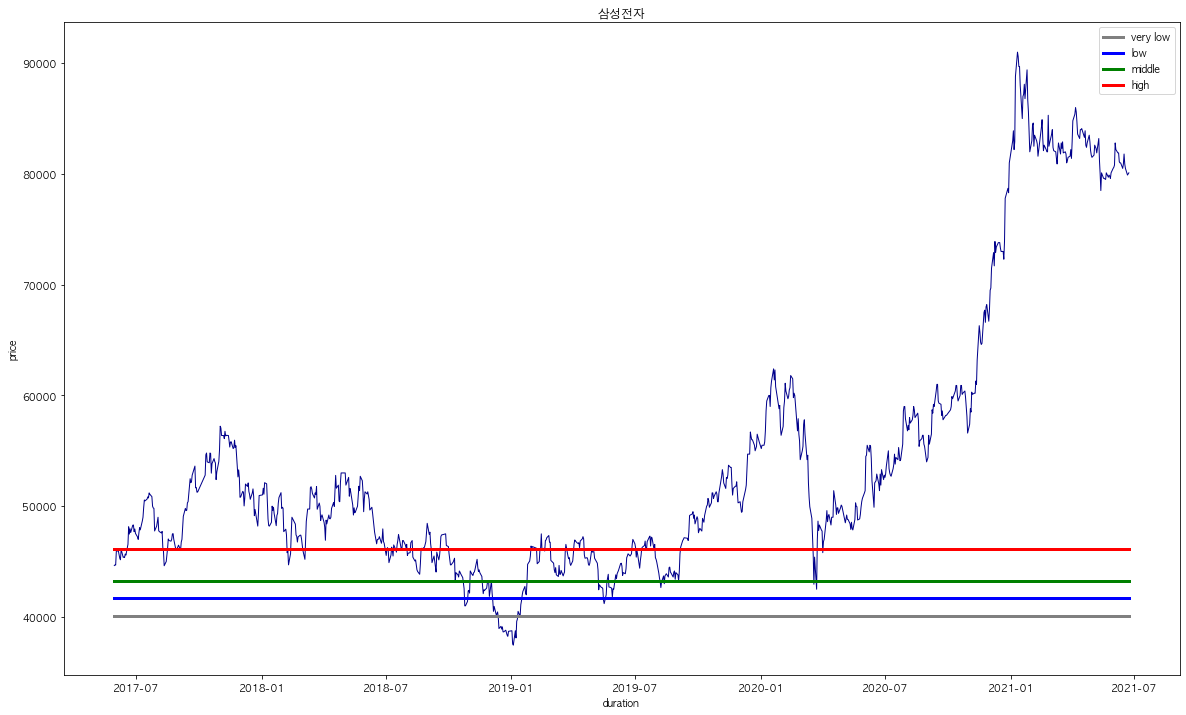

In [50]:
nq.show_price_chart(company_code, company_name, price_df)